# Winter 2026 COMP 579 Assignment 3

Group: 31

Names: 
- Miguel Ángel Carrillo Cobián - 261205372
- Matheus da Silva Araujo - 261218407

## 3) (a)


3) (a) [6 points] In reinforcement learning (RL), environments are not merely “scorer” of an algorithm; they provide essential structure and insight for interpreting agent behavior.
Before conducting algorithmic experiments, it is advisable to analyze and visualize the environment itself, as this helps understand why different algorithms exhibit varying performance.
Show visualizations (a few images is enough) of the Breakout-v1 environment by executing a small number of random actions, and provide a concise description of what is shown in the
resulting outputs. Additionally, print the specifications of the observation space and action space of the environment, which define its input and output interfaces.

### Random Actions & Specifications Printing

===== Environment Specifications =====
Number of actions: 6
Observation shape: (10, 10, 4)
Observation dtype: bool
Observation values: min = False , max = True


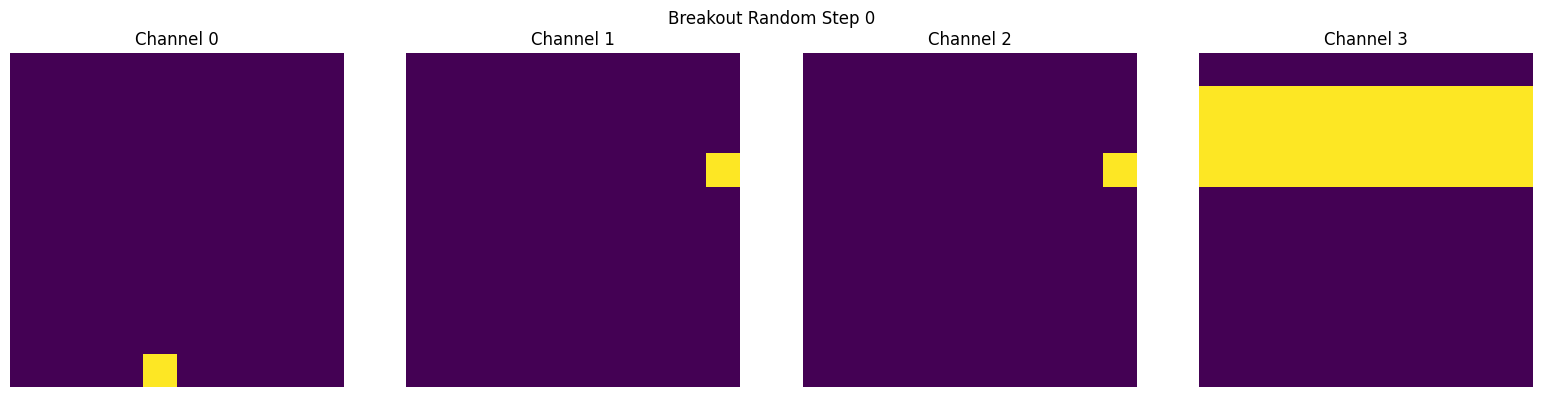

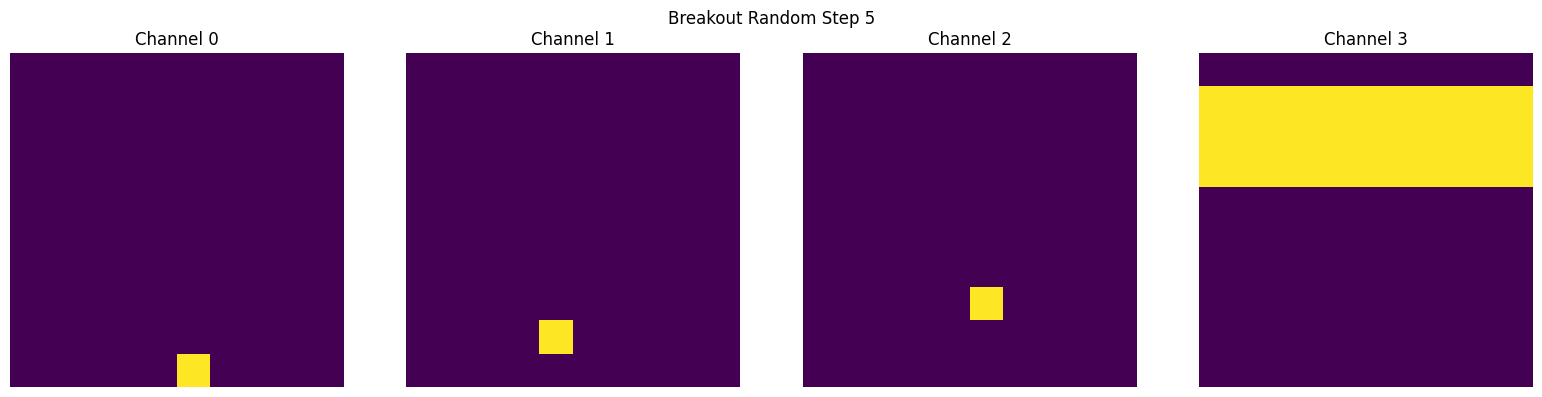

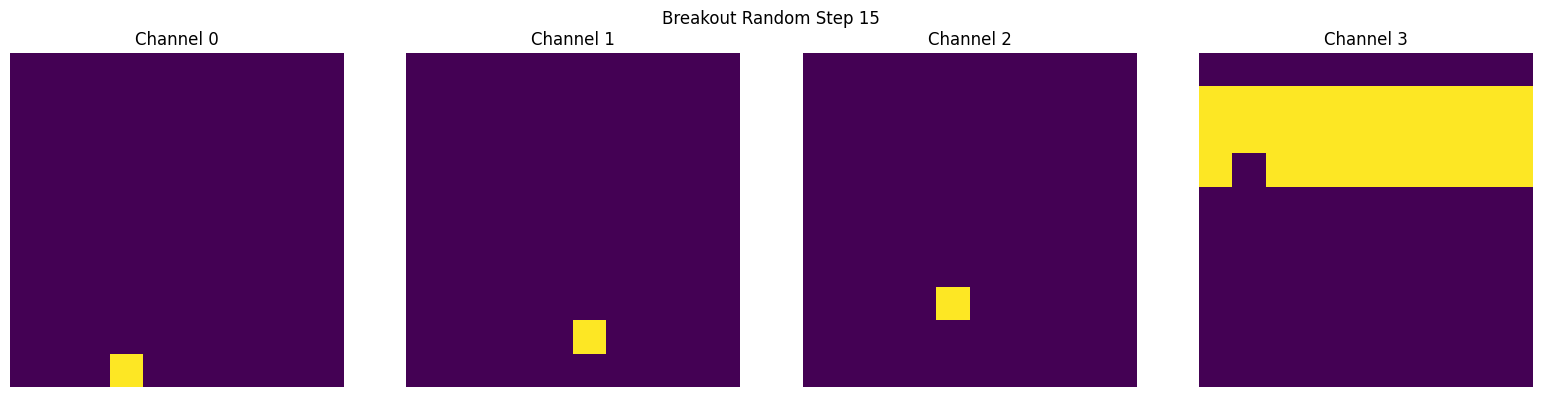

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from minatar import Environment

env = Environment("breakout")

print("===== Environment Specifications =====")
print("Number of actions:", env.num_actions())

state = env.state()
print("Observation shape:", state.shape)
print("Observation dtype:", state.dtype)
print("Observation values:", "min =", state.min(), ", max =", state.max())

env.reset()
terminated = False

show_steps = [0, 5, 15, 30]
max_step = max(show_steps)
t = 0

while not terminated and t <= max_step:
    if t in show_steps:
        state = env.state()  # (H, W, C)
        n_channels = state.shape[2]

        fig, axes = plt.subplots(1, n_channels, figsize=(4 * n_channels, 4))
        if n_channels == 1:
            axes = [axes]

        for i in range(n_channels):
            axes[i].imshow(state[:, :, i], interpolation="nearest")
            axes[i].set_title(f"Channel {i}")
            axes[i].axis("off")

        fig.suptitle(f"Breakout Random Step {t}")
        fig.tight_layout()
        plt.show()

    action = random.randrange(env.num_actions())
    reward, terminated = env.act(action)
    t += 1


### Ordered Actions

Number of actions: 6


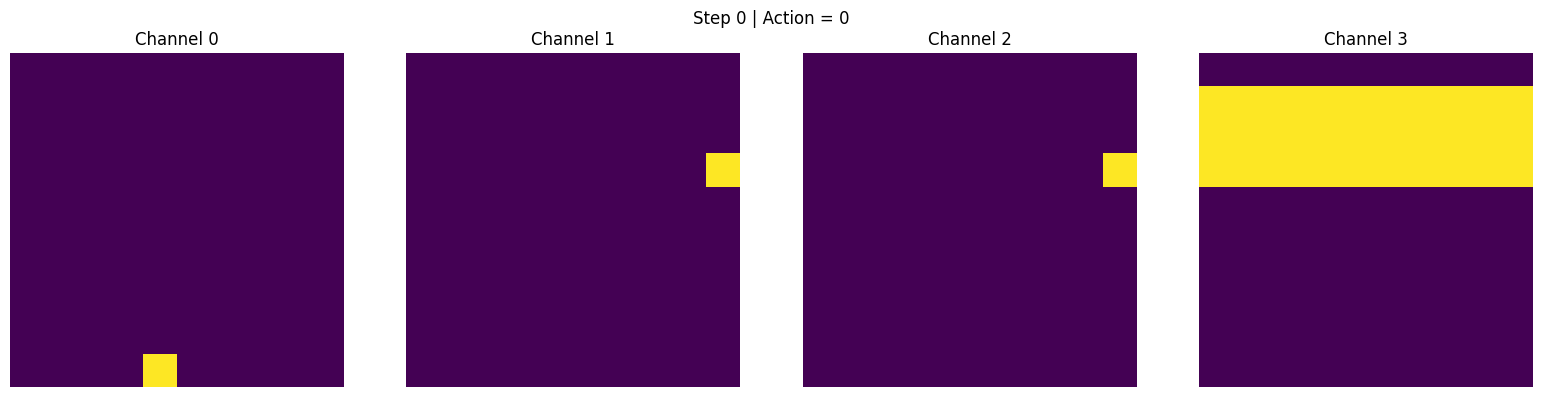

Step 0 | Took action 0 | Reward = 0


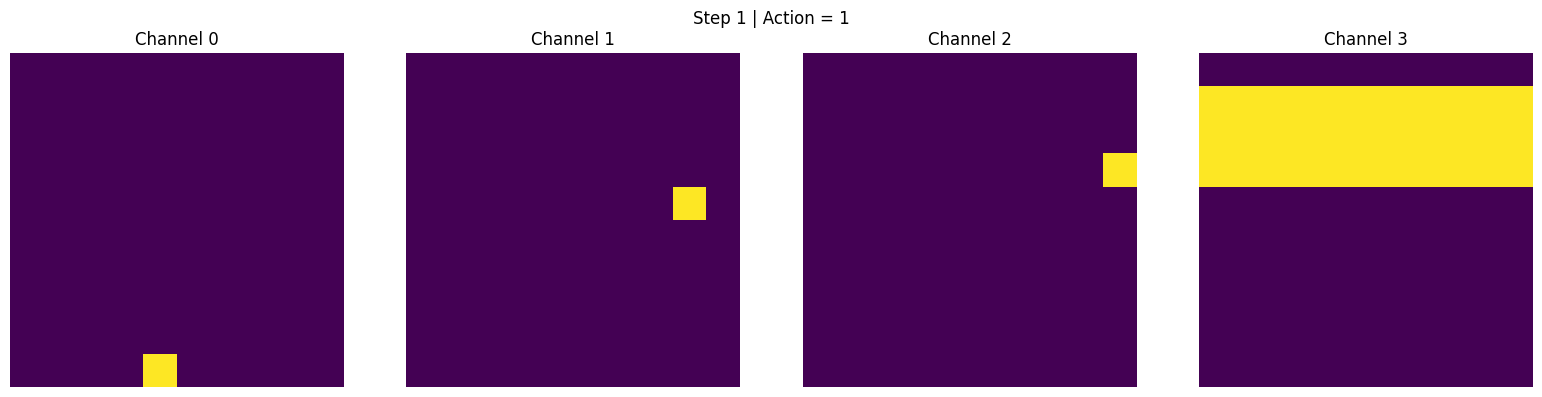

Step 1 | Took action 1 | Reward = 0


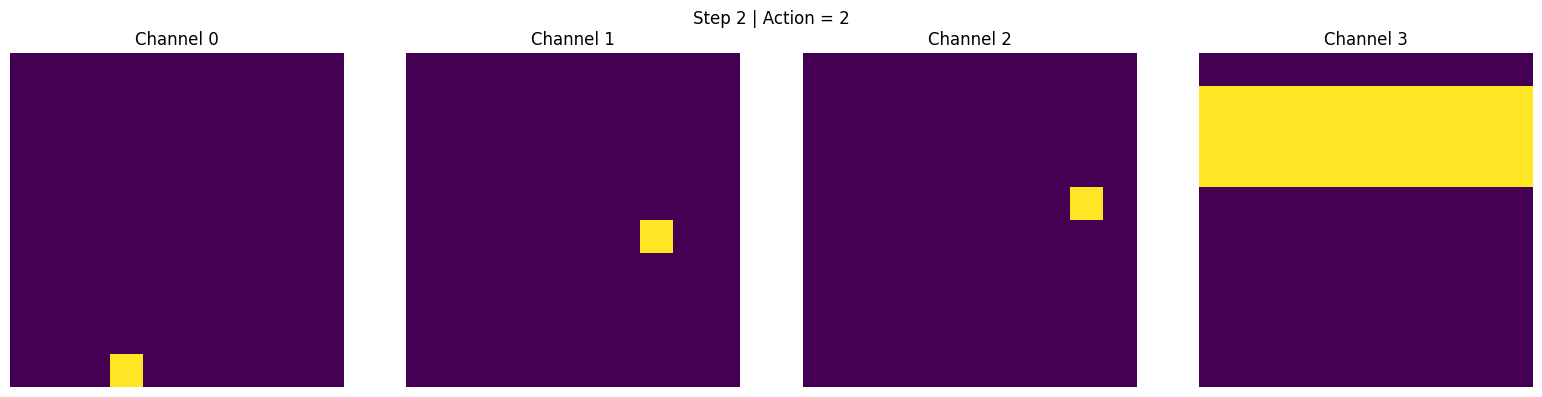

Step 2 | Took action 2 | Reward = 0


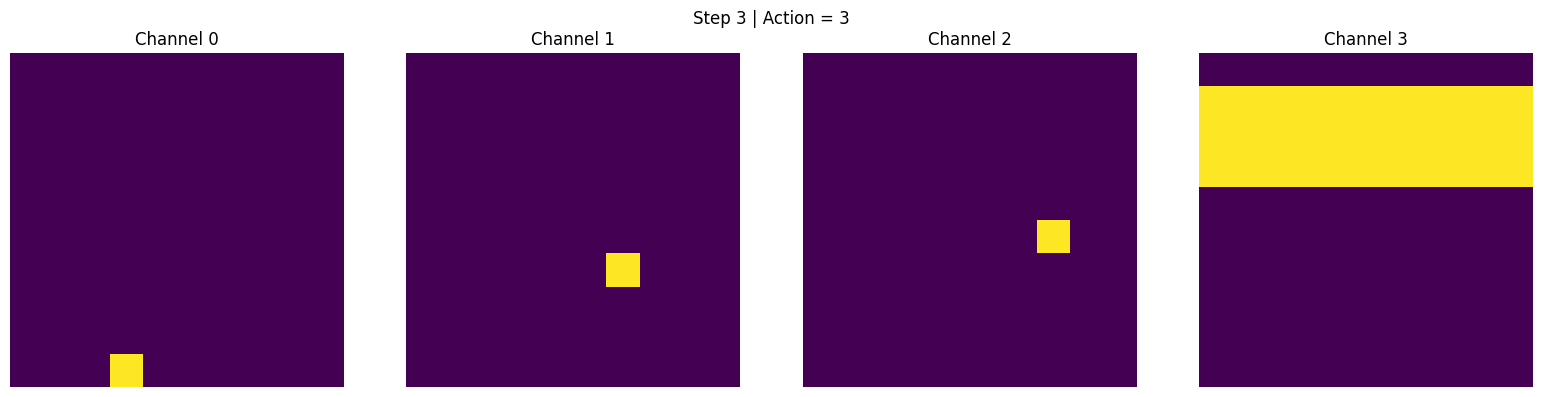

Step 3 | Took action 3 | Reward = 0


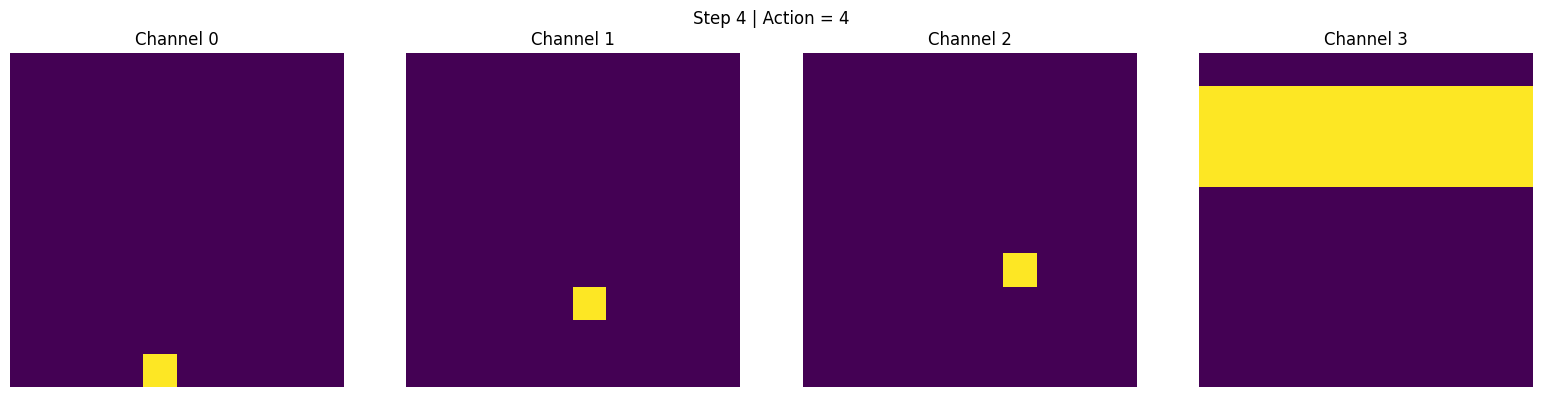

Step 4 | Took action 4 | Reward = 0


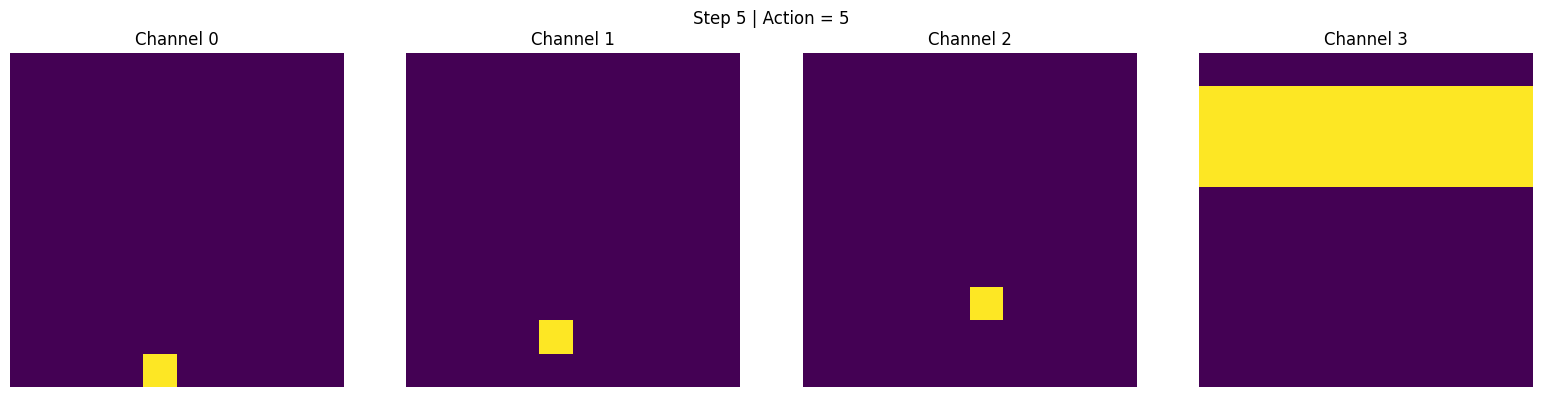

Step 5 | Took action 5 | Reward = 0


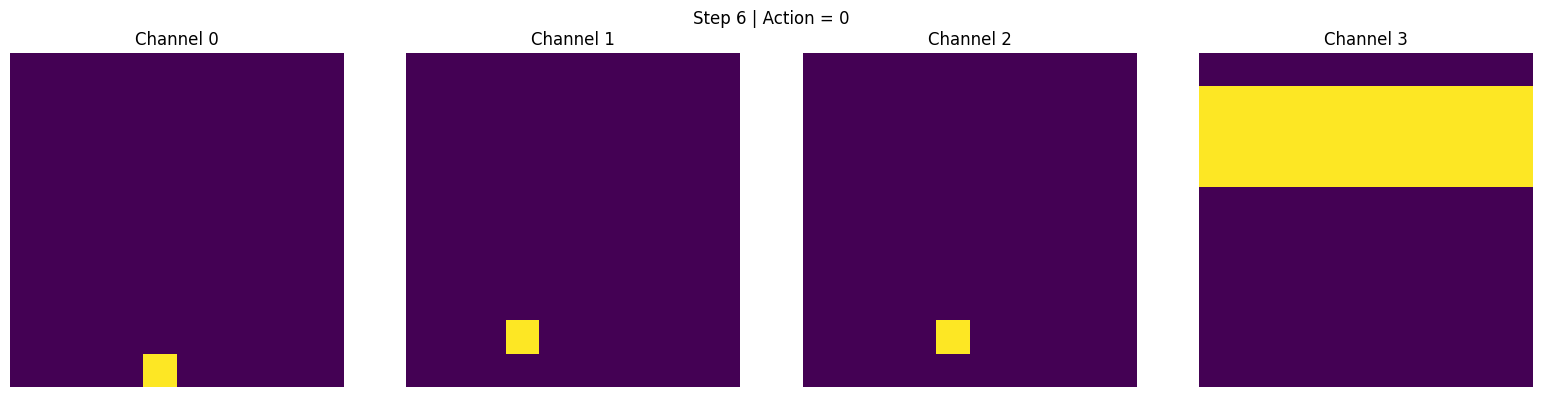

Step 6 | Took action 0 | Reward = 0


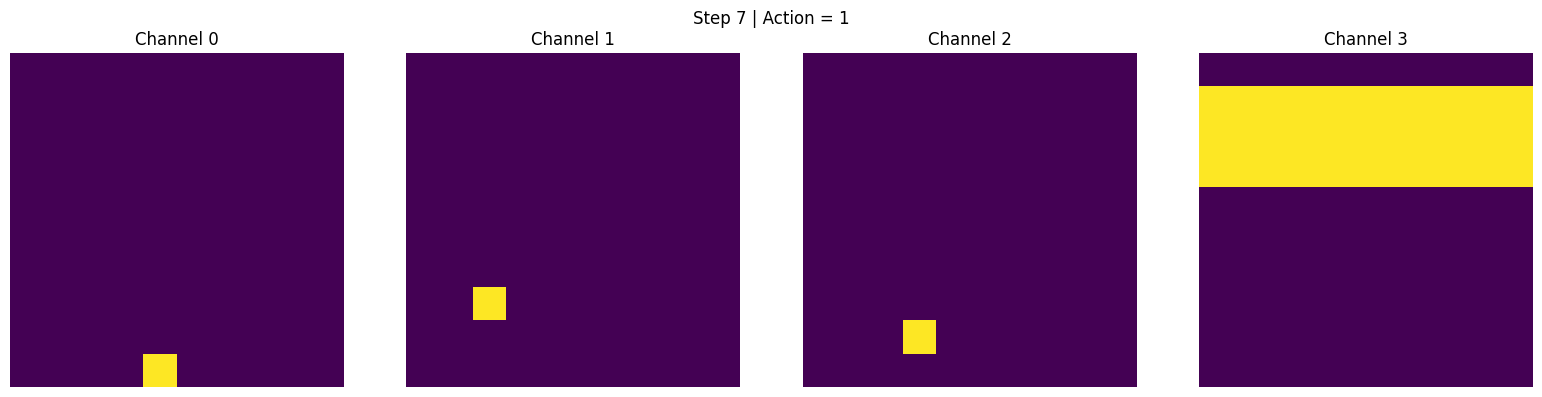

Step 7 | Took action 1 | Reward = 0


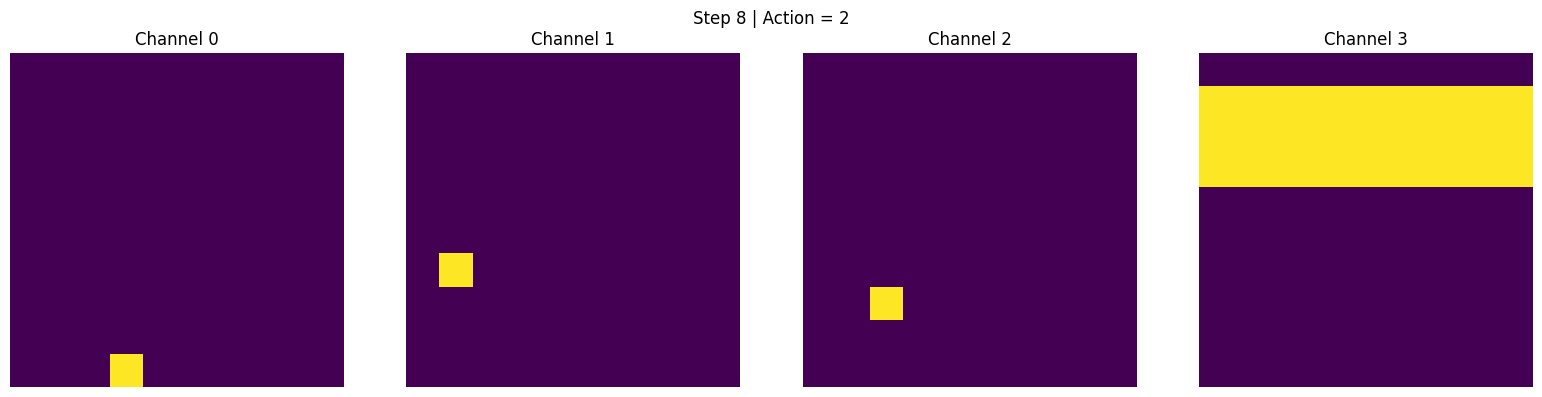

Step 8 | Took action 2 | Reward = 0


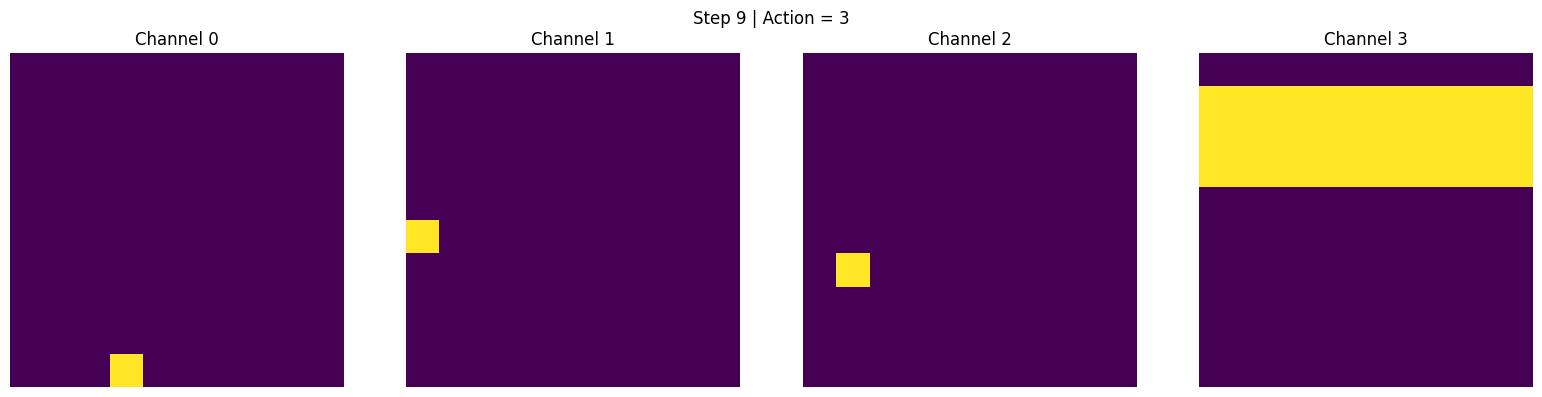

Step 9 | Took action 3 | Reward = 0


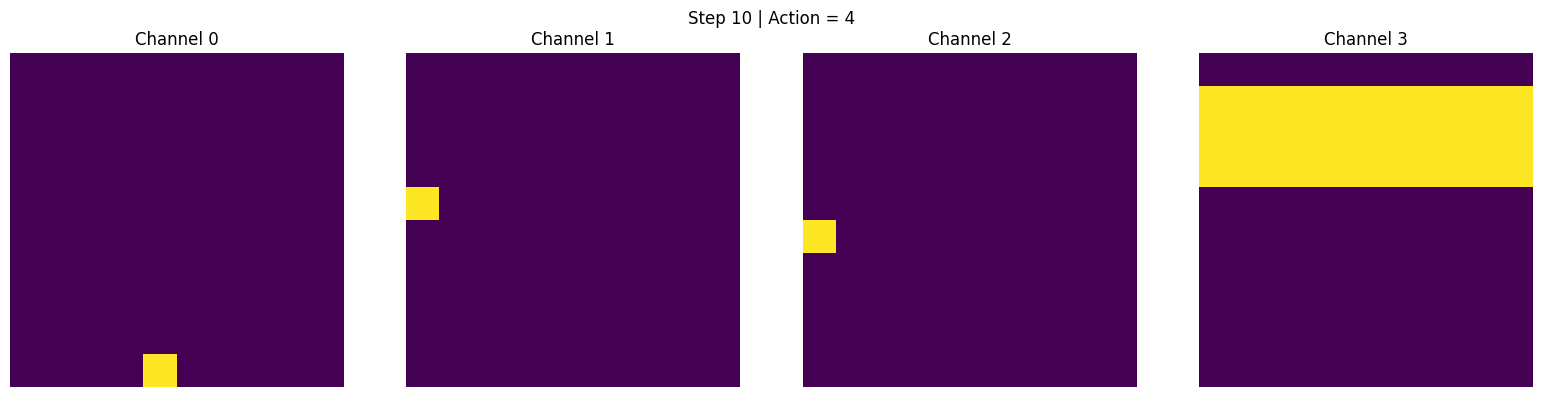

Step 10 | Took action 4 | Reward = 1


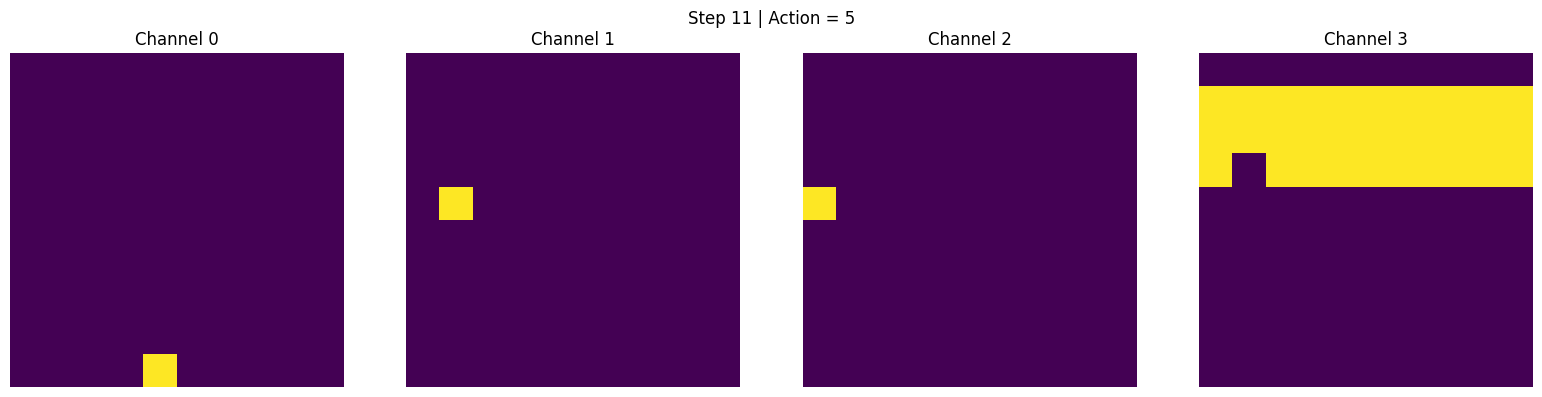

Step 11 | Took action 5 | Reward = 0


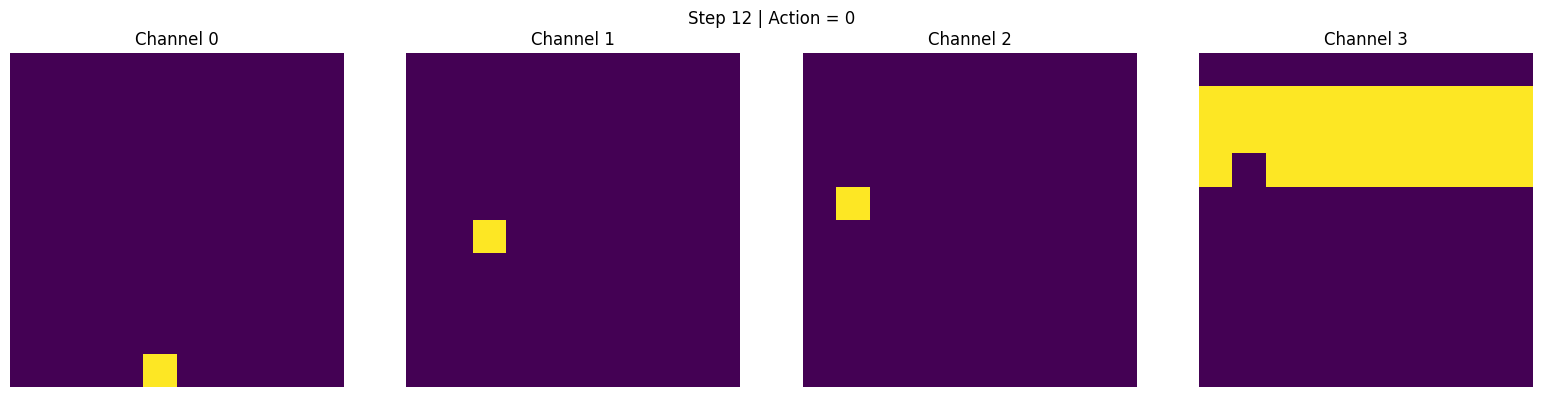

Step 12 | Took action 0 | Reward = 0


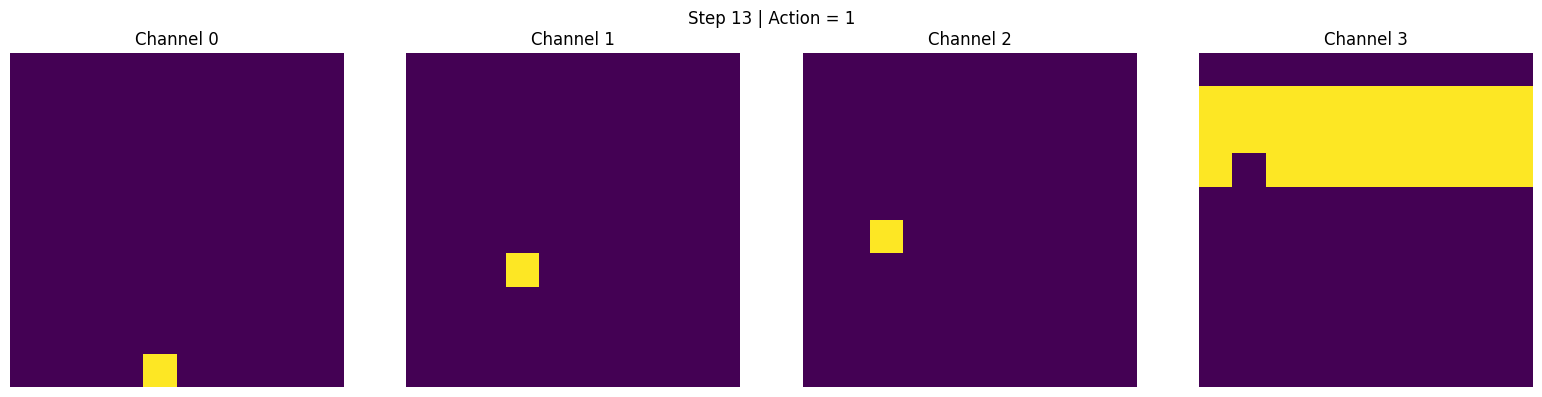

Step 13 | Took action 1 | Reward = 0


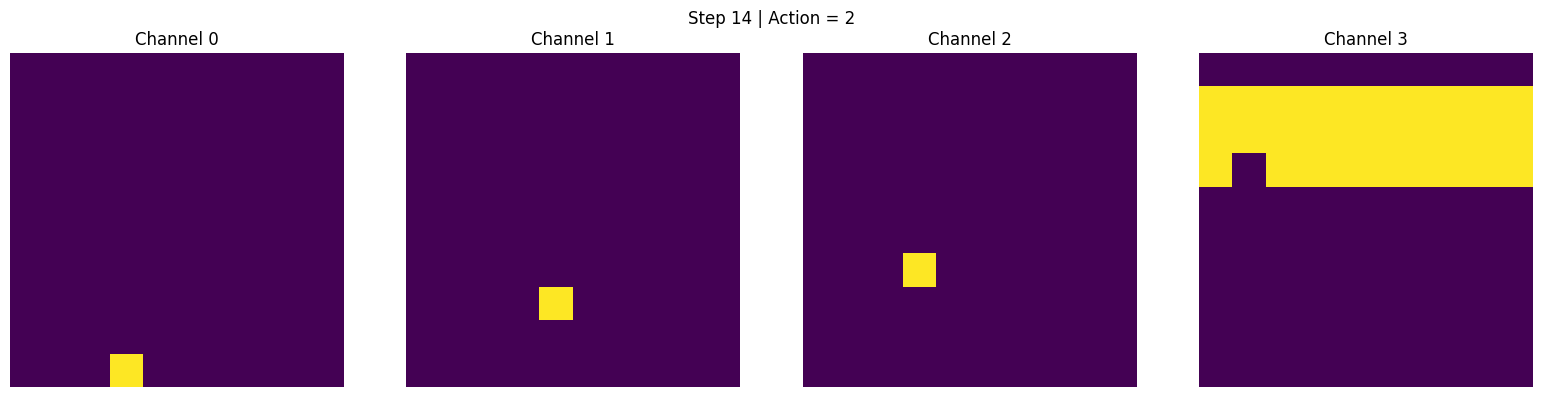

Step 14 | Took action 2 | Reward = 0


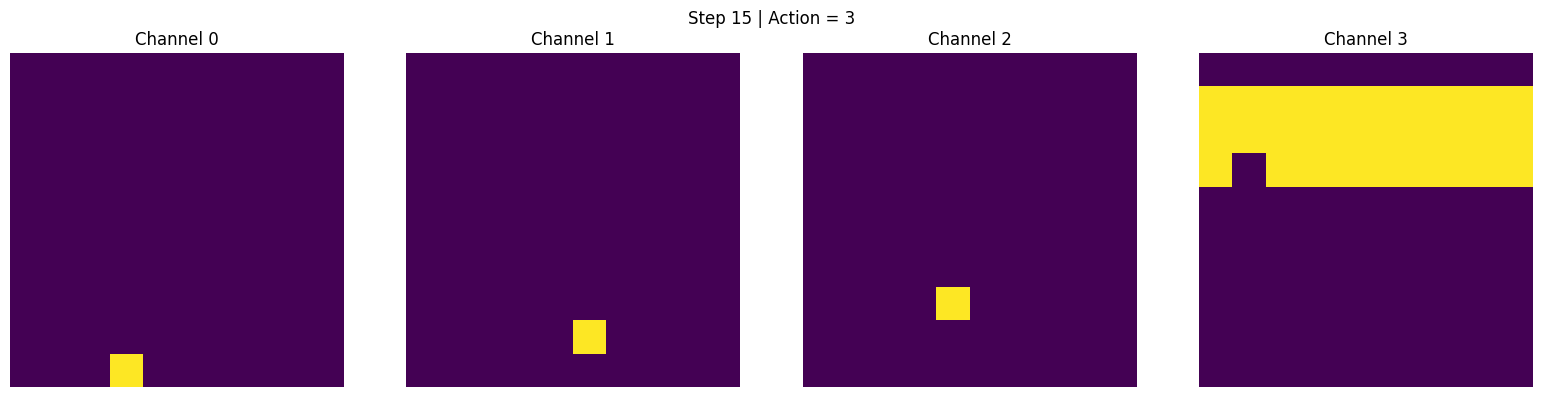

Step 15 | Took action 3 | Reward = 0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from minatar import Environment

env = Environment("breakout")
env.reset()

print("Number of actions:", env.num_actions())

terminated = False
t = 0
max_steps = 20

while not terminated and t < max_steps:

    # ---- Display current state ----
    state = env.state()  # (H, W, C)
    n_channels = state.shape[2]

    fig, axes = plt.subplots(1, n_channels, figsize=(4 * n_channels, 4))

    if n_channels == 1:
        axes = [axes]

    for i in range(n_channels):
        axes[i].imshow(state[:, :, i], interpolation="nearest")
        axes[i].set_title(f"Channel {i}")
        axes[i].axis("off")

    fig.suptitle(f"Step {t} | Action = {t % env.num_actions()}")
    fig.tight_layout()

    #clear_output(wait=True)   # makes it update like animation
    display(fig)
    plt.close(fig)

    # ---- Deterministic action sequence ----
    action = t % env.num_actions()
    reward, terminated = env.act(action)

    print(f"Step {t} | Took action {action} | Reward = {reward}")

    t += 1

### Description of Environment and Action Space

The environment provides observations of shape (10, 10, 4) with Boolean values {True, False}. Each observation consists of four 10×10 binary channels, which can be visualized as pixel grids (False = purple, True = yellow). Each channel represents a game component:

- Channel 0: Player paddle
- Channel 1: Ball
- Channel 2: Ball trail
- Channel 3: Bricks (targets)

This structured representation separates objects into different feature maps, simplifying perception compared to raw image inputs.

The action space consists of 6 discrete actions (integers 0–5). From visualization:

- 0: No move
- 1: Move paddle left
- 2: No move
- 3: Move paddle right
- 4: No move
- 5: No move

Only two actions directly affect the paddle position, the others introduce redundancy in the action space.

A reward of +1 is observed when the ball (Channel 1) collides with a brick (Channel 3), causing the brick to disappear.

## (a1) (extra)

(a1) [Optional, 3 bonus points, you can’t have more than 100 points] Carefully inspect the dynamics of the Breakout-v1 environment and its visualizations. Based on empirical
investigation and/or reading the environment implementation, discuss whether there exists a small design issue that could make the observation process slightly non-Markovian when
each episode initiates. (Don’t worry, the experiment result won’t change significantly because of this!)

### Response:

There is a small design detail that may make the observation process slightly non-Markovian at episode initialization. Even if the ball’s position is observable, its velocity (direction of motion) is not explicitly encoded in the initial observation because both, the ball and its trail are in the same position. We have two identical initial observations could correspond to different internal velocity states, leading to different next-state transitions. This violates strict Markovity at the first time step. However, after one transition, the ball trail channel reveals motion direction, making the process Markovian.

## (b1) 

(b) [24 points] Control with experience replay. Implement Deep Q-learning under:

- (i) Sequential updates (no replay buffer, use the most recent experience to update).
- (ii) Experience replay with uniform sampling.
- (iii) Experience replay with prioritized sampling.

Use a target network that is updated via hard parameter copying every 1000 environment steps. For the replay buffer, use capacity 50,000 and perform mini-batch TD updates with
batch size 64. For prioritized replay, specify the sampling rule based on TD error and include importance-sampling corrections. For each setting, test under different learning rates
𝛼 = {1𝑒−4, 5𝑒−4, 1𝑒−3}, and plot those three curves within one figure. Compare performance across the three settings and provide plausible explanations for the observed results. The
analysis should consider both environmental characteristics and algorithmic properties.

In [3]:
import os
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow # For versioning

from minatar import Environment

# Import plotting function
from plotting import plot_compare_smoothed_rewards


# -------------------------
# Config
# -------------------------
@dataclass
class DQNConfig:
    env_name: str = "breakout"
    gamma: float = 0.99
    epsilon: float = 0.05
    hidden_dim: int = 128
    init_low: float = -0.001
    init_high: float = 0.001

    warmup_steps: int = 1000
    target_update_every: int = 1000  # env steps
    episodes: int = 3000
    max_steps_per_episode: int = 1000  # safety cap

    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# -------------------------
# Utils
# -------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # deterministic-ish (may reduce speed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def obs_to_tensor(obs: np.ndarray, device: str) -> torch.Tensor:
    # MinAtar state is (10,10,C) bool; convert to float and flatten
    x = obs.astype(np.float32).reshape(-1)
    return torch.from_numpy(x).to(device)


def discounted_return(rewards: List[float], gamma: float) -> float:
    G = 0.0
    p = 1.0
    for r in rewards:
        G += p * r
        p *= gamma
    return G


# -------------------------
# Network
# -------------------------
class QNetwork(nn.Module):
    def __init__(self, input_dim: int, num_actions: int, hidden_dim: int,
                 init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions),
        )
        self._init_weights(init_low, init_high)

    def _init_weights(self, low: float, high: float):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, a=low, b=high)
                nn.init.uniform_(m.bias, a=low, b=high)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


# -------------------------
# Action selection
# -------------------------
@torch.no_grad()
def epsilon_greedy_action(qnet: QNetwork, s: torch.Tensor, epsilon: float, num_actions: int) -> int:
    if random.random() < epsilon:
        return random.randrange(num_actions)
    q = qnet(s.unsqueeze(0))  # (1, A)
    return int(torch.argmax(q, dim=1).item())


# -------------------------
# One run (one seed, one lr)
# -------------------------
def run_dqn_sequential(seed: int, lr: float, cfg: DQNConfig) -> List[float]:
    set_seed(seed)

    env = Environment(cfg.env_name)
    num_actions = env.num_actions()

    # Determine input dim from an initial state
    env.reset()
    s0 = env.state()
    input_dim = int(np.prod(s0.shape))  # 10*10*C

    q = QNetwork(input_dim, num_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    q_tgt = QNetwork(input_dim, num_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    q_tgt.load_state_dict(q.state_dict())
    q_tgt.eval()

    optimizer = optim.Adam(q.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    env_steps = 0
    total_env_steps = 0

    # -------------------------
    # Warm-up: act randomly (or epsilon-greedy) and do NOT update
    # For sequential-updates, we still follow the "1000 warm-up steps" requirement.
    # -------------------------
    env.reset()
    terminated = False
    while env_steps < cfg.warmup_steps:
        if terminated:
            env.reset()
            terminated = False

        a = random.randrange(num_actions)  # pure random warmup
        r, terminated = env.act(a)
        env_steps += 1

    # -------------------------
    # Training
    # -------------------------
    episode_returns: List[float] = []

    for ep in range(cfg.episodes):
        env.reset()
        terminated = False
        ep_rewards: List[float] = []
        steps_in_ep = 0

        while not terminated and steps_in_ep < cfg.max_steps_per_episode:
            obs = env.state()
            s = obs_to_tensor(obs, cfg.device)

            # Choose action
            a = epsilon_greedy_action(q, s, cfg.epsilon, num_actions)

            # Step env
            r, terminated = env.act(a)
            ep_rewards.append(float(r))

            # Next state
            obs2 = env.state()
            s2 = obs_to_tensor(obs2, cfg.device)

            # -------------------------
            # Sequential TD update (batch size = 1 transition)
            # target = r + gamma * max_a' Q_tgt(s', a') if not done
            # -------------------------
            with torch.no_grad():
                q_next = q_tgt(s2.unsqueeze(0))           # (1, A)
                max_q_next = torch.max(q_next, dim=1)[0]  # (1,)
                y = torch.tensor([r], device=cfg.device, dtype=torch.float32)
                if not terminated:
                    y = y + cfg.gamma * max_q_next

            q_sa = q(s.unsqueeze(0))[0, a]  # scalar
            loss = loss_fn(q_sa, y.squeeze(0))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            env_steps += 1
            steps_in_ep += 1
            total_env_steps += 1

            # Target network hard update
            if env_steps % cfg.target_update_every == 0:
                q_tgt.load_state_dict(q.state_dict())

        G = discounted_return(ep_rewards, cfg.gamma)
        episode_returns.append(G)

        if (ep + 1) % 50 == 0:
            print(f"[lr={lr} | seed={seed}] "
                f"Episode {ep+1}/{cfg.episodes} | "
                f"Steps this ep: {steps_in_ep} | "
                f"Total env steps: {total_env_steps}")

        # MLflow
        if (ep + 1) % 50 == 0:
            mlflow.log_metric("discounted_return", float(G), step=ep)

    return episode_returns


# -------------------------
# Sweep: 3 learning rates, 5 seeds
# -------------------------
def experiment_sequential(cfg: DQNConfig,
                          lrs=(1e-4, 5e-4, 1e-3),
                          seeds=(0, 1, 2, 3, 4),
                          mlflow_experiment_name="COMP579_A3_DQN_Sequential"):

    mlflow.set_experiment(mlflow_experiment_name)

    # store as: lr -> list over seeds -> returns list over episodes
    results: Dict[float, List[List[float]]] = {}

    for lr in lrs:
        per_seed_returns: List[List[float]] = []

        # Parent run for this LR
        with mlflow.start_run(run_name=f"sequential_lr={lr}", nested=False):
            mlflow.log_params({
                "setting": "sequential_updates",
                "env": cfg.env_name,
                "lr": lr,
                "gamma": cfg.gamma,
                "epsilon": cfg.epsilon,
                "warmup_steps": cfg.warmup_steps,
                "target_update_every": cfg.target_update_every,
                "episodes": cfg.episodes,
                "hidden_dim": cfg.hidden_dim,
                "init_low": cfg.init_low,
                "init_high": cfg.init_high,
                "optimizer": "Adam",
            })

            for seed in seeds:
                with mlflow.start_run(run_name=f"seed={seed}", nested=True):
                    mlflow.log_param("seed", seed)
                    returns = run_dqn_sequential(seed=seed, lr=lr, cfg=cfg)
                    per_seed_returns.append(returns)

                    # log final performance summary too
                    mlflow.log_metric("final_100ep_mean_return", float(np.mean(returns[-100:])))

        results[lr] = per_seed_returns

    # Plot: three curves (each curve = mean±std across seeds) for the three lrs
    train_rewards_list = [results[lr] for lr in lrs]
    labels = [f"α={lr:g}" for lr in lrs]

    plot_compare_smoothed_rewards(
        train_rewards_list=train_rewards_list,
        labels=labels,
        window=10,
        xlabel="Episode",
        ylabel="Discounted return",
    )

    return results

d:\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[lr=0.0001 | seed=0] Episode 50/3000 | Steps this ep: 6 | Total env steps: 580
[lr=0.0001 | seed=0] Episode 100/3000 | Steps this ep: 26 | Total env steps: 1182
[lr=0.0001 | seed=0] Episode 150/3000 | Steps this ep: 6 | Total env steps: 1712
[lr=0.0001 | seed=0] Episode 200/3000 | Steps this ep: 6 | Total env steps: 2142
[lr=0.0001 | seed=0] Episode 250/3000 | Steps this ep: 6 | Total env steps: 2712
[lr=0.0001 | seed=0] Episode 300/3000 | Steps this ep: 6 | Total env steps: 3012
[lr=0.0001 | seed=0] Episode 350/3000 | Steps this ep: 16 | Total env steps: 3422
[lr=0.0001 | seed=0] Episode 400/3000 | Steps this ep: 6 | Total env steps: 3842
[lr=0.0001 | seed=0] Episode 450/3000 | Steps this ep: 6 | Total env steps: 4142
[lr=0.0001 | seed=0] Episode 500/3000 | Steps this ep: 6 | Total env steps: 4544
[lr=0.0001 | seed=0] Episode 550/3000 | Steps this ep: 6 | Total env steps: 4924
[lr=0.0001 | seed=0] Episode 600/3000 | Steps this ep: 6 | Total env steps: 5426
[lr=0.0001 | seed=0] Episode

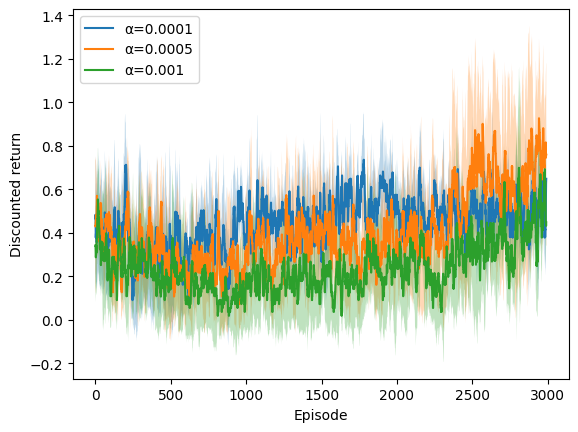

In [4]:
cfg = DQNConfig()
results = experiment_sequential(cfg)

### (b)(ii)

In [5]:
import os
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow

from minatar import Environment
from plotting import plot_compare_smoothed_rewards


# -------------------------
# Config (same as before)
# -------------------------
@dataclass
class DQNConfig:
    env_name: str = "breakout"
    gamma: float = 0.99
    epsilon: float = 0.05
    hidden_dim: int = 128
    init_low: float = -0.001
    init_high: float = 0.001

    warmup_steps: int = 1000
    target_update_every: int = 1000
    episodes: int = 3000
    max_steps_per_episode: int = 1000

    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# -------------------------
# Utils (same as before)
# -------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def obs_to_tensor(obs: np.ndarray, device: str) -> torch.Tensor:
    x = obs.astype(np.float32).reshape(-1)
    return torch.from_numpy(x).to(device)


def discounted_return(rewards: List[float], gamma: float) -> float:
    G = 0.0
    p = 1.0
    for r in rewards:
        G += p * r
        p *= gamma
    return G


# -------------------------
# Network (same as before)
# -------------------------
class QNetwork(nn.Module):
    def __init__(self, input_dim: int, num_actions: int, hidden_dim: int,
                 init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions),
        )
        self._init_weights(init_low, init_high)

    def _init_weights(self, low: float, high: float):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, a=low, b=high)
                nn.init.uniform_(m.bias, a=low, b=high)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


@torch.no_grad()
def epsilon_greedy_action(qnet: QNetwork, s: torch.Tensor, epsilon: float, num_actions: int) -> int:
    if random.random() < epsilon:
        return random.randrange(num_actions)
    q = qnet(s.unsqueeze(0))
    return int(torch.argmax(q, dim=1).item())


# -------------------------
# Replay Buffer (uniform sampling)
# -------------------------
class ReplayBuffer:
    def __init__(self, capacity: int, obs_dim: int):
        self.capacity = capacity
        self.obs_dim = obs_dim
        self.ptr = 0
        self.size = 0

        self.s = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.a = np.zeros((capacity,), dtype=np.int64)
        self.r = np.zeros((capacity,), dtype=np.float32)
        self.s2 = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.done = np.zeros((capacity,), dtype=np.float32)  # 1.0 if done else 0.0

    def add(self, s, a, r, s2, done: bool):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s2[self.ptr] = s2
        self.done[self.ptr] = 1.0 if done else 0.0

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int):
        idx = np.random.randint(0, self.size, size=batch_size)
        return self.s[idx], self.a[idx], self.r[idx], self.s2[idx], self.done[idx]

    def __len__(self):
        return self.size


# -------------------------
# (b)(ii) One run: uniform replay
# -------------------------
def run_dqn_replay_uniform(seed: int, lr: float, cfg: DQNConfig,
                           buffer_capacity: int = 50_000,
                           batch_size: int = 64) -> List[float]:
    set_seed(seed)

    env = Environment(cfg.env_name)
    num_actions = env.num_actions()

    env.reset()
    s0 = env.state()
    obs_dim = int(np.prod(s0.shape))

    q = QNetwork(obs_dim, num_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    q_tgt = QNetwork(obs_dim, num_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    q_tgt.load_state_dict(q.state_dict())
    q_tgt.eval()

    optimizer = optim.Adam(q.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    # IMPORTANT: buffer must be cleared for each seed -> new buffer per run
    rb = ReplayBuffer(capacity=buffer_capacity, obs_dim=obs_dim)

    env_steps = 0
    total_env_steps = 0

    # -------- Warm-up: collect experience only (no updates) --------
    env.reset()
    terminated = False
    while env_steps < cfg.warmup_steps:
        if terminated:
            env.reset()
            terminated = False

        obs = env.state().astype(np.float32).reshape(-1)
        a = random.randrange(num_actions)
        r, terminated = env.act(a)
        obs2 = env.state().astype(np.float32).reshape(-1)

        rb.add(obs, a, float(r), obs2, terminated)
        env_steps += 1

    # -------- Training --------
    episode_returns: List[float] = []

    for ep in range(cfg.episodes):
        env.reset()
        terminated = False
        ep_rewards: List[float] = []
        steps_in_ep = 0

        while not terminated and steps_in_ep < cfg.max_steps_per_episode:
            obs = env.state().astype(np.float32).reshape(-1)
            s = torch.from_numpy(obs).to(cfg.device)

            a = epsilon_greedy_action(q, s, cfg.epsilon, num_actions)

            r, terminated = env.act(a)
            ep_rewards.append(float(r))

            obs2 = env.state().astype(np.float32).reshape(-1)

            # store transition
            rb.add(obs, a, float(r), obs2, terminated)

            # ----- One gradient step per env step -----
            # (buffer should already be >= warmup, but still guard)
            if len(rb) >= batch_size:
                bs, ba, br, bs2, bdone = rb.sample(batch_size)

                bs_t = torch.from_numpy(bs).to(cfg.device)
                ba_t = torch.from_numpy(ba).to(cfg.device)
                br_t = torch.from_numpy(br).to(cfg.device)
                bs2_t = torch.from_numpy(bs2).to(cfg.device)
                bdone_t = torch.from_numpy(bdone).to(cfg.device)

                # Q(s,a)
                q_values = q(bs_t)  # (B, A)
                q_sa = q_values.gather(1, ba_t.view(-1, 1)).squeeze(1)  # (B,)

                with torch.no_grad():
                    q_next = q_tgt(bs2_t)                  # (B, A)
                    max_q_next = torch.max(q_next, dim=1)[0]  # (B,)
                    y = br_t + (1.0 - bdone_t) * cfg.gamma * max_q_next

                loss = loss_fn(q_sa, y)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            env_steps += 1
            steps_in_ep += 1
            total_env_steps += 1

            # Target network hard update
            if env_steps % cfg.target_update_every == 0:
                q_tgt.load_state_dict(q.state_dict())

        G = discounted_return(ep_rewards, cfg.gamma)
        episode_returns.append(G)

        if (ep + 1) % 50 == 0:
            print(f"[lr={lr} | seed={seed}] "
                f"Episode {ep+1}/{cfg.episodes} | "
                f"Steps this ep: {steps_in_ep} | "
                f"Total env steps: {total_env_steps}")
    
        # MLflow
        if (ep + 1) % 50 == 0:
            mlflow.log_metric("discounted_return", float(G), step=ep)

    return episode_returns


# -------------------------
# Experiment: 3 learning rates x 5 seeds
# -------------------------
def experiment_replay_uniform(cfg: DQNConfig,
                              lrs=(1e-4, 5e-4, 1e-3),
                              seeds=(0, 1, 2, 3, 4),
                              mlflow_experiment_name="COMP579_A3_DQN_Replay_Uniform"):

    mlflow.set_experiment(mlflow_experiment_name)

    results: Dict[float, List[List[float]]] = {}

    for lr in lrs:
        per_seed_returns: List[List[float]] = []

        with mlflow.start_run(run_name=f"uniform_replay_lr={lr}", nested=False):
            mlflow.log_params({
                "setting": "replay_uniform",
                "env": cfg.env_name,
                "lr": lr,
                "gamma": cfg.gamma,
                "epsilon": cfg.epsilon,
                "warmup_steps": cfg.warmup_steps,
                "target_update_every": cfg.target_update_every,
                "episodes": cfg.episodes,
                "hidden_dim": cfg.hidden_dim,
                "init_low": cfg.init_low,
                "init_high": cfg.init_high,
                "optimizer": "Adam",
                "replay_capacity": 50_000,
                "batch_size": 64,
            })

            for seed in seeds:
                with mlflow.start_run(run_name=f"seed={seed}", nested=True):
                    mlflow.log_param("seed", seed)
                    returns = run_dqn_replay_uniform(seed=seed, lr=lr, cfg=cfg,
                                                     buffer_capacity=50_000, batch_size=64)
                    per_seed_returns.append(returns)
                    mlflow.log_metric("final_100ep_mean_return", float(np.mean(returns[-100:])))

        results[lr] = per_seed_returns

    train_rewards_list = [results[lr] for lr in lrs]
    labels = [f"α={lr:g}" for lr in lrs]

    plot_compare_smoothed_rewards(
        train_rewards_list=train_rewards_list,
        labels=labels,
        window=10,
        xlabel="Episode",
        ylabel="Discounted return",
    )

    return results

2026/02/21 16:06:05 INFO mlflow.tracking.fluent: Experiment with name 'COMP579_A3_DQN_Replay_Uniform' does not exist. Creating a new experiment.


[lr=0.0001 | seed=0] Episode 50/3000 | Steps this ep: 6 | Total env steps: 550
[lr=0.0001 | seed=0] Episode 100/3000 | Steps this ep: 6 | Total env steps: 1000
[lr=0.0001 | seed=0] Episode 150/3000 | Steps this ep: 16 | Total env steps: 1540
[lr=0.0001 | seed=0] Episode 200/3000 | Steps this ep: 6 | Total env steps: 1900
[lr=0.0001 | seed=0] Episode 250/3000 | Steps this ep: 6 | Total env steps: 2392
[lr=0.0001 | seed=0] Episode 300/3000 | Steps this ep: 16 | Total env steps: 2832
[lr=0.0001 | seed=0] Episode 350/3000 | Steps this ep: 16 | Total env steps: 3352
[lr=0.0001 | seed=0] Episode 400/3000 | Steps this ep: 6 | Total env steps: 3934
[lr=0.0001 | seed=0] Episode 450/3000 | Steps this ep: 6 | Total env steps: 4504
[lr=0.0001 | seed=0] Episode 500/3000 | Steps this ep: 6 | Total env steps: 5084
[lr=0.0001 | seed=0] Episode 550/3000 | Steps this ep: 6 | Total env steps: 5584
[lr=0.0001 | seed=0] Episode 600/3000 | Steps this ep: 6 | Total env steps: 6144
[lr=0.0001 | seed=0] Episod

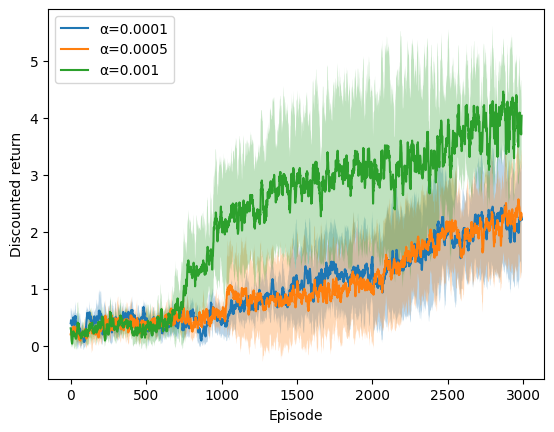

In [6]:
cfg = DQNConfig()
results = experiment_replay_uniform(cfg)

### (b)(iii)

In [7]:
# DQN for COMP579 A3 (Breakout-v1 MinAtar)
# (b)(iii) Experience Replay with PRIORITIZED sampling (TD-error based) + IS corrections
# This file is designed to be copy-pasted as-is.
#
# Reuses the same structure as (b)(i)/(b)(ii):
# - Same QNetwork, epsilon-greedy, obs preprocessing, discounted return, MLflow structure
# - ReplayBuffer is extended (not replaced) to support prioritized sampling via the same .sample() call
#
# Requirements satisfied:
# - Target network hard copy every 1000 env steps
# - Replay capacity 50,000
# - Mini-batch size 64
# - 1 gradient step per env step
# - Warm-up 1000 steps (collect experience, no updates)
# - γ=0.99, ε=0.05
# - MLP: 2 hidden layers, 128 units, ReLU; init U(-0.001, 0.001)
# - Adam optimizer
# - Average 5 seeds
# - Plot 3 learning rates α ∈ {1e-4, 5e-4, 1e-3} on one figure using provided plotting.py

import random
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import mlflow

from minatar import Environment
from plotting import plot_compare_smoothed_rewards


# -------------------------
# Config (same as before)
# -------------------------
@dataclass
class DQNConfig:
    env_name: str = "breakout"
    gamma: float = 0.99
    epsilon: float = 0.05

    hidden_dim: int = 128
    init_low: float = -0.001
    init_high: float = 0.001

    warmup_steps: int = 1000
    target_update_every: int = 1000  # env steps

    episodes: int = 3000
    max_steps_per_episode: int = 1000  # safety cap

    device: str = "cuda" if torch.cuda.is_available() else "cpu"


# -------------------------
# Utils (same as before)
# -------------------------
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def obs_to_np_flat(obs: np.ndarray) -> np.ndarray:
    # MinAtar obs is bool (10,10,C) -> float32 flat vector
    return obs.astype(np.float32).reshape(-1)


def obs_to_tensor(obs_flat: np.ndarray, device: str) -> torch.Tensor:
    return torch.from_numpy(obs_flat).to(device)


def discounted_return(rewards: List[float], gamma: float) -> float:
    G = 0.0
    p = 1.0
    for r in rewards:
        G += p * r
        p *= gamma
    return G


# -------------------------
# Network (same as before)
# -------------------------
class QNetwork(nn.Module):
    def __init__(self, input_dim: int, num_actions: int, hidden_dim: int,
                 init_low: float, init_high: float):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_actions),
        )
        self._init_weights(init_low, init_high)

    def _init_weights(self, low: float, high: float):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, a=low, b=high)
                nn.init.uniform_(m.bias, a=low, b=high)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


@torch.no_grad()
def epsilon_greedy_action(qnet: QNetwork, s: torch.Tensor, epsilon: float, num_actions: int) -> int:
    if random.random() < epsilon:
        return random.randrange(num_actions)
    q = qnet(s.unsqueeze(0))
    return int(torch.argmax(q, dim=1).item())


# -------------------------
# Replay Buffer (Uniform + Prioritized via same sample() method)
# -------------------------
class ReplayBuffer:
    def __init__(self, capacity: int, obs_dim: int,
                 prioritized: bool = False,
                 prio_alpha: float = 0.6,
                 prio_eps: float = 1e-6):
        self.capacity = capacity
        self.obs_dim = obs_dim
        self.ptr = 0
        self.size = 0

        self.s = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.a = np.zeros((capacity,), dtype=np.int64)
        self.r = np.zeros((capacity,), dtype=np.float32)
        self.s2 = np.zeros((capacity, obs_dim), dtype=np.float32)
        self.done = np.zeros((capacity,), dtype=np.float32)

        # Prioritized replay storage
        self.prioritized = prioritized
        self.prio_alpha = prio_alpha
        self.prio_eps = prio_eps
        self.prio = np.zeros((capacity,), dtype=np.float32)
        self.max_prio = 1.0

    def add(self, s, a, r, s2, done: bool):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s2[self.ptr] = s2
        self.done[self.ptr] = 1.0 if done else 0.0

        # Set new transition priority to current maximum so it has a chance to be sampled
        if self.prioritized:
            self.prio[self.ptr] = self.max_prio

        self.ptr = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size: int, beta: float = 0.4):
        """
        If prioritized=False: uniform sample, returns (batch, None, None)
        If prioritized=True: proportional prioritized sample, returns (batch, idx, is_weights)
        """
        if self.size == 0:
            raise ValueError("Cannot sample from empty buffer")

        if not self.prioritized:
            idx = np.random.randint(0, self.size, size=batch_size)
            return (self.s[idx], self.a[idx], self.r[idx], self.s2[idx], self.done[idx]), None, None

        # proportional prioritization: P(i) ∝ (|δ_i| + eps)^alpha  (we store prio already as positive scalar)
        prios = self.prio[:self.size].copy()
        scaled = np.power(prios + self.prio_eps, self.prio_alpha)
        probs = scaled / np.sum(scaled)

        idx = np.random.choice(self.size, size=batch_size, replace=True, p=probs)

        # importance sampling weights: w_i = (N * P(i))^{-beta}, normalize by max in batch
        N = self.size
        w = np.power(N * probs[idx], -beta).astype(np.float32)
        w /= (w.max() + 1e-8)

        batch = (self.s[idx], self.a[idx], self.r[idx], self.s2[idx], self.done[idx])
        return batch, idx, w

    def update_priorities(self, idx: np.ndarray, td_errors: np.ndarray):
        """
        Update priorities based on TD-error magnitude.
        Priority rule: p_i = |δ_i| + eps
        """
        if not self.prioritized:
            return
        new_p = np.abs(td_errors).astype(np.float32) + self.prio_eps
        self.prio[idx] = new_p
        self.max_prio = max(self.max_prio, float(new_p.max()))

    def __len__(self):
        return self.size


# -------------------------
# (b)(iii) One run: prioritized replay
# -------------------------
def run_dqn_replay_prioritized(seed: int, lr: float, cfg: DQNConfig,
                               buffer_capacity: int = 50_000,
                               batch_size: int = 64,
                               prio_alpha: float = 0.6,
                               beta_start: float = 0.4,
                               beta_end: float = 1.0) -> List[float]:
    set_seed(seed)

    env = Environment(cfg.env_name)
    num_actions = env.num_actions()

    env.reset()
    obs_dim = int(np.prod(env.state().shape))

    q = QNetwork(obs_dim, num_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    q_tgt = QNetwork(obs_dim, num_actions, cfg.hidden_dim, cfg.init_low, cfg.init_high).to(cfg.device)
    q_tgt.load_state_dict(q.state_dict())
    q_tgt.eval()

    optimizer = optim.Adam(q.parameters(), lr=lr)

    # Buffer must be cleared per seed: create a fresh one here
    rb = ReplayBuffer(capacity=buffer_capacity, obs_dim=obs_dim,
                      prioritized=True, prio_alpha=prio_alpha)

    env_steps = 0
    total_env_steps = 0

    # -------- Warm-up: collect experience only (no updates) --------
    env.reset()
    terminated = False
    while env_steps < cfg.warmup_steps:
        if terminated:
            env.reset()
            terminated = False

        s = obs_to_np_flat(env.state())
        a = random.randrange(num_actions)  # random warmup
        r, terminated = env.act(a)
        s2 = obs_to_np_flat(env.state())
        rb.add(s, a, float(r), s2, terminated)
        env_steps += 1

    # -------- Training --------
    episode_returns: List[float] = []

    for ep in range(cfg.episodes):
        env.reset()
        terminated = False
        ep_rewards: List[float] = []
        steps_in_ep = 0

        # Anneal beta linearly over episodes (simple + standard)
        frac = ep / max(1, cfg.episodes - 1)
        beta = beta_start + frac * (beta_end - beta_start)

        while not terminated and steps_in_ep < cfg.max_steps_per_episode:
            s_np = obs_to_np_flat(env.state())
            s = obs_to_tensor(s_np, cfg.device)

            a = epsilon_greedy_action(q, s, cfg.epsilon, num_actions)
            r, terminated = env.act(a)
            ep_rewards.append(float(r))

            s2_np = obs_to_np_flat(env.state())

            rb.add(s_np, a, float(r), s2_np, terminated)

            # ----- One gradient step per env step -----
            if len(rb) >= batch_size:
                (bs, ba, br, bs2, bdone), idx, is_w = rb.sample(batch_size, beta=beta)

                bs_t = torch.from_numpy(bs).to(cfg.device)
                ba_t = torch.from_numpy(ba).to(cfg.device)
                br_t = torch.from_numpy(br).to(cfg.device)
                bs2_t = torch.from_numpy(bs2).to(cfg.device)
                bdone_t = torch.from_numpy(bdone).to(cfg.device)

                # Q(s,a)
                q_values = q(bs_t)  # (B, A)
                q_sa = q_values.gather(1, ba_t.view(-1, 1)).squeeze(1)  # (B,)

                with torch.no_grad():
                    q_next = q_tgt(bs2_t)  # (B, A)
                    max_q_next = torch.max(q_next, dim=1)[0]  # (B,)
                    y = br_t + (1.0 - bdone_t) * cfg.gamma * max_q_next  # (B,)

                td_err = (q_sa - y)  # (B,)

                # Importance-sampled loss: mean( w_i * (δ_i)^2 )
                w_t = torch.from_numpy(is_w).to(cfg.device)
                loss = torch.mean(w_t * (td_err ** 2))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update priorities from TD-error (detach to numpy)
                rb.update_priorities(idx, td_errors=td_err.detach().cpu().numpy())

            env_steps += 1
            steps_in_ep += 1
            total_env_steps += 1

            # Target network hard update
            if env_steps % cfg.target_update_every == 0:
                q_tgt.load_state_dict(q.state_dict())

        G = discounted_return(ep_rewards, cfg.gamma)
        episode_returns.append(G)

        if (ep + 1) % 50 == 0:
            print(f"[lr={lr} | seed={seed}] "
                f"Episode {ep+1}/{cfg.episodes} | "
                f"Steps this ep: {steps_in_ep} | "
                f"Total env steps: {total_env_steps}")

        # MLflow
        if (ep + 1) % 50 == 0:
            mlflow.log_metric("discounted_return", float(G), step=ep)

    return episode_returns


# -------------------------
# Experiment: 3 learning rates x 5 seeds (Prioritized Replay)
# -------------------------
def experiment_replay_prioritized(cfg: DQNConfig,
                                  lrs=(1e-4, 5e-4, 1e-3),
                                  seeds=(0, 1, 2, 3, 4),
                                  mlflow_experiment_name="COMP579_A3_DQN_Replay_Prioritized"):

    mlflow.set_experiment(mlflow_experiment_name)

    results: Dict[float, List[List[float]]] = {}

    for lr in lrs:
        per_seed_returns: List[List[float]] = []

        with mlflow.start_run(run_name=f"prioritized_replay_lr={lr}", nested=False):
            mlflow.log_params({
                "setting": "replay_prioritized",
                "env": cfg.env_name,
                "lr": lr,
                "gamma": cfg.gamma,
                "epsilon": cfg.epsilon,
                "warmup_steps": cfg.warmup_steps,
                "target_update_every": cfg.target_update_every,
                "episodes": cfg.episodes,
                "hidden_dim": cfg.hidden_dim,
                "init_low": cfg.init_low,
                "init_high": cfg.init_high,
                "optimizer": "Adam",
                "replay_capacity": 50_000,
                "batch_size": 64,
                "prio_alpha": 0.6,
                "beta_start": 0.4,
                "beta_end": 1.0,
                "prio_eps": 1e-6,
            })

            for seed in seeds:
                with mlflow.start_run(run_name=f"seed={seed}", nested=True):
                    mlflow.log_param("seed", seed)

                    returns = run_dqn_replay_prioritized(
                        seed=seed,
                        lr=lr,
                        cfg=cfg,
                        buffer_capacity=50_000,
                        batch_size=64,
                        prio_alpha=0.6,
                        beta_start=0.4,
                        beta_end=1.0,
                    )
                    per_seed_returns.append(returns)

                    mlflow.log_metric("final_100ep_mean_return", float(np.mean(returns[-100:])))

        results[lr] = per_seed_returns

    # Plot 3 curves (mean±std across seeds) for the 3 learning rates
    train_rewards_list = [results[lr] for lr in lrs]
    labels = [f"α={lr:g}" for lr in lrs]

    plot_compare_smoothed_rewards(
        train_rewards_list=train_rewards_list,
        labels=labels,
        window=10,
        xlabel="Episode",
        ylabel="Discounted return",
    )

    return results

2026/02/21 16:58:31 INFO mlflow.tracking.fluent: Experiment with name 'COMP579_A3_DQN_Replay_Prioritized' does not exist. Creating a new experiment.


[lr=0.0001 | seed=0] Episode 50/3000 | Steps this ep: 16 | Total env steps: 512
[lr=0.0001 | seed=0] Episode 100/3000 | Steps this ep: 6 | Total env steps: 1002
[lr=0.0001 | seed=0] Episode 150/3000 | Steps this ep: 6 | Total env steps: 1434
[lr=0.0001 | seed=0] Episode 200/3000 | Steps this ep: 6 | Total env steps: 1734
[lr=0.0001 | seed=0] Episode 250/3000 | Steps this ep: 28 | Total env steps: 2098
[lr=0.0001 | seed=0] Episode 300/3000 | Steps this ep: 16 | Total env steps: 2690
[lr=0.0001 | seed=0] Episode 350/3000 | Steps this ep: 16 | Total env steps: 3280
[lr=0.0001 | seed=0] Episode 400/3000 | Steps this ep: 6 | Total env steps: 3840
[lr=0.0001 | seed=0] Episode 450/3000 | Steps this ep: 6 | Total env steps: 4360
[lr=0.0001 | seed=0] Episode 500/3000 | Steps this ep: 6 | Total env steps: 4904
[lr=0.0001 | seed=0] Episode 550/3000 | Steps this ep: 38 | Total env steps: 5468
[lr=0.0001 | seed=0] Episode 600/3000 | Steps this ep: 16 | Total env steps: 6078
[lr=0.0001 | seed=0] Epi

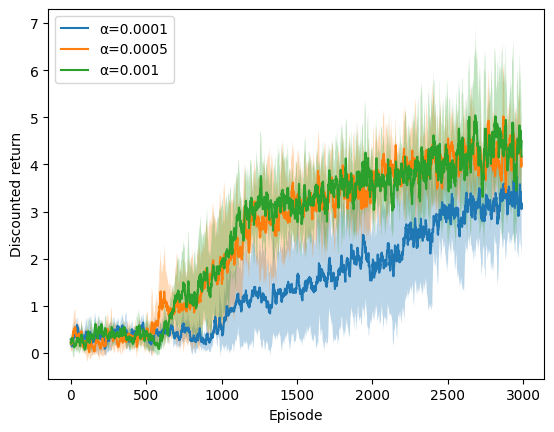

In [8]:
cfg = DQNConfig()
results = experiment_replay_prioritized(cfg)

### Insights & Conclusions

#### b (i) Sequential DQN (No Replay Buffer)

For the DQN implementation with sequential updates, based on the Discounted Return vs Episode curves we observe that variance is quite high and learning is intermittent. The curves are noisy and improvements are unstable across episodes.

For α = 0.001, we see the lowest discounted return during most of training, although after approximately episode 2500 a plausible upward trend appears. For α = 0.0001, we observe the highest average discounted reward until around episode 2500. After that point, α = 0.0005 begins to exhibit clearer learning behaviour and eventually surpasses the others. From episodes 2500 to 3000, α = 0.0005 achieves the highest discounted return among the three learning rates.

In all three cases, learning is slow and inconsistent. Even after 3000 episodes, the discounted returns averaged across 5 seeds do not surpass 1. This suggests that the instability is primarily due to the update mechanism, not the network architecture, since the architecture is identical across experiments. As will be shown in the following settings, using the same network and hyperparameters but modifying the update strategy leads to significantly higher performance.

The poor performance of sequential updates can be explained by:

- Strong correlation between consecutive samples.
- Non-stationary target values due to online updates.
- High variance in TD targets.

These factors are especially problematic in a sparse-reward environment like this one, where reward is only received when a brick is destroyed.

#### b (ii) DQN with Experience Replay (Uniform Sampling)

For DQN with experience replay using uniform sampling, the results improve significantly and the plots become much easier to interpret.

For α = 0.001, we observe the best overall performance. The curve shows a clear learning trajectory, reaching a discounted return close to 4 by episode 3000. For α = 0.0001 and α = 0.0005, performance is similar, with both achieving slightly above 2 in discounted return by episode 3000. In all three cases, learning behaviour is clearly visible and much more stable compared to sequential updates.

The improvement can be attributed to:

- Breaking temporal correlations by sampling randomly from the buffer.
- Reusing past experiences multiple times.
- Stabilizing the target distribution.

In this setting, the larger learning rate (α = 0.001) performs best. Since the environment is relatively small (10×10 grid, discrete actions, simple dynamics), a larger learning rate can accelerate convergence without causing severe divergence. However, the variance of α = 0.001 appears higher than that of smaller learning rates, indicating increased update magnitude and sensitivity to noise.

#### b (iii) DQN with Prioritized Experience Replay

Finally, we consider DQN with prioritized experience replay.

This setting yields the best overall results. Clear learning behaviour is observed for all learning rates, and discounted returns are consistently higher than in the previous two methods.

The best learning rate is α = 0.001, reaching over 4.5 in discounted return by episode 3000. This is slightly better than α = 0.0005, which performs similarly but remains marginally lower. The worst-performing learning rate is α = 0.0001, which still achieves over 3 in discounted return by episode 3000 — significantly better than sequential updates and uniform replay with the same learning rate.

The improvement from prioritized replay can be explained by:

- Sampling transitions with larger TD error more frequently.
- Focusing updates on informative or surprising transitions.
- Improving sample efficiency.

Unlike sequential updates, prioritized replay reduces variance and accelerates propagation of meaningful reward signals.

#### Conclusions

As expected from theory, experience replay with prioritized sampling outperforms the other two approaches. Experience replay stabilizes learning by decorrelating samples and approximating the i.i.d. assumption of supervised learning. Prioritized sampling further improves performance by emphasizing transitions with large TD errors, which accelerates value propagation.

It is important to clarify one point: prioritized replay does not solve an “off-policy distribution mismatch problem.” DQN is already off-policy. Instead, prioritized replay improves sample efficiency and learning speed by biasing the sampling distribution toward high-TD-error transitions while correcting for that bias using importance sampling.

The environment also plays an important role. Breakout has:

- A small discrete action space (6 actions, but effectively only 2 meaningful ones).
- Sparse rewards (reward only when bricks are destroyed).
- Simple state representation (binary 10×10×4 grid).

Because the state and action spaces are relatively small, higher learning rates can perform well without causing instability. However, sparse rewards make correlated updates particularly harmful, which explains why sequential DQN performs poorly compared to replay-based methods. Overall, the results demonstrate that:

- Sequential updates suffer from instability and poor sample efficiency.
- Uniform replay significantly improves stability and learning speed.
- Prioritized replay provides the best performance by focusing updates on informative transitions.